Created on Wed Aug 08 2018

@author: ncaplar@princeton.edu

Packaged which you need that are a bit more advanced:

1. pandas
2. tqdm (for monitoring calculations)
3. DELCgen (https://github.com/samconnolly/DELightcurveSimulation) - this requires Python2



This cell below contains some extensions that I use that make life much easier when using jupyter notebook 
These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

In [159]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}



<IPython.core.display.Javascript object>

In [160]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [165]:
%load_ext autoreload
%autoreload 2

#import statments
import numpy as np
import pandas as pd
import io
from tqdm import tqdm
from __future__ import division

import MS_Variability
from MS_Variability import get_ACF,get_scatter_MS,get_mean_relation, bootstrap_resample,create_MS_scatter_at_given_t_interpolation,create_Number_of_sigmas,create_offset_slope_at_given_t_interpolation,create_Number_of_sigmas_offset

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Theoretical Analysis 

## Looking at ACF

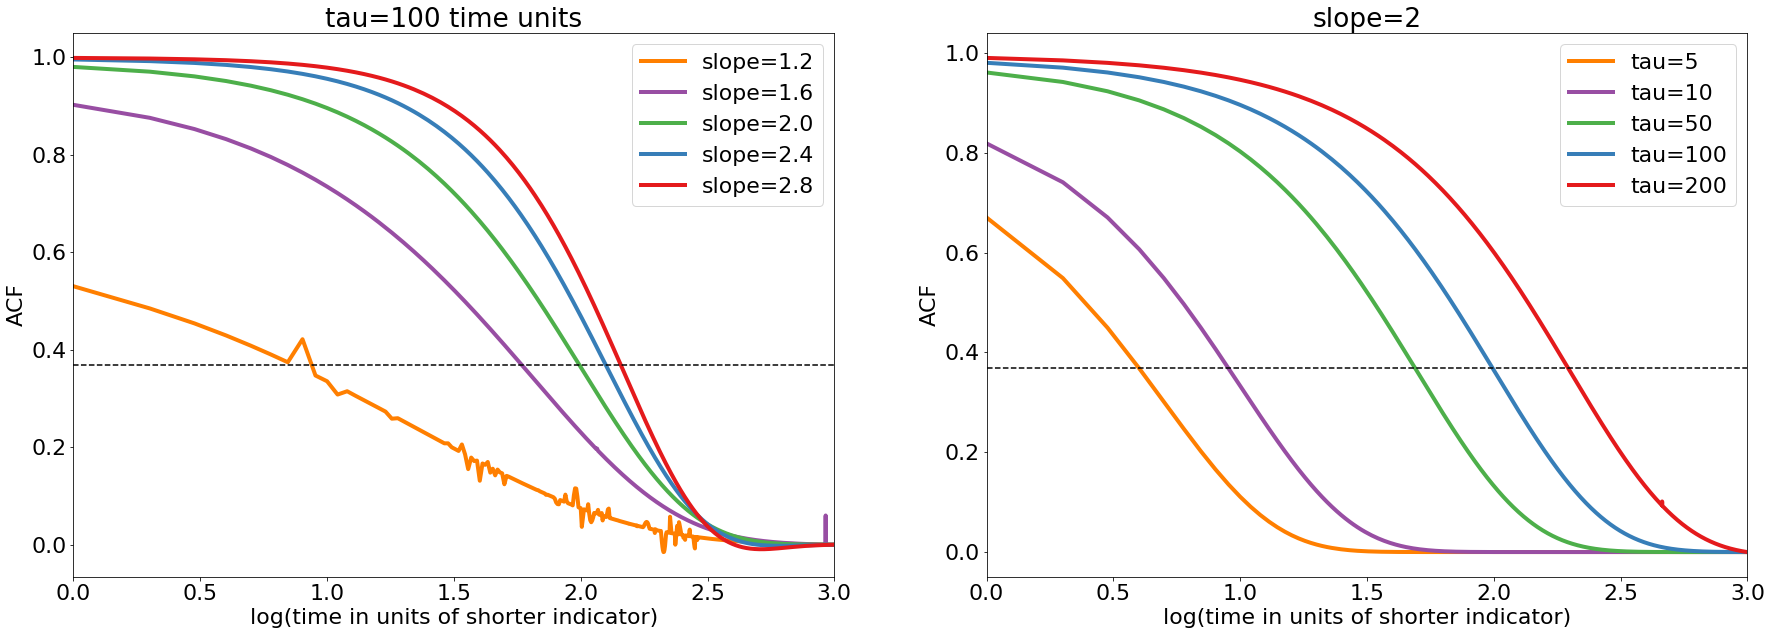

In [211]:
"""
Example showing how ACF depend on slope and tau
For slope 2 (damped random walk) we know the exact result that ACF(t)=exp(-t/tau)
We can verify below that ACF(100)=1/exp(-1) for the case of slope=2

colors from colorbrewer2.org

One can also notice numerical instabilities in the numerical integration for shallow slopes
"""
plot_slope=2
plot_tau=100


plt.figure(figsize=(30,10))

plt.subplot(121)

ACF_Example1=get_ACF(plot_tau,1.2)
ACF_Example2=get_ACF(plot_tau,1.6)
ACF_Example3=get_ACF(plot_tau,2)
ACF_Example4=get_ACF(plot_tau,2.4)
ACF_Example5=get_ACF(plot_tau,2.8)

plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4)
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='#4daf4a',label='slope=2.0',lw=4)
plt.plot(np.log10(ACF_Example4[:,0]),ACF_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4)
plt.plot(np.log10(ACF_Example5[:,0]),ACF_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4)

plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('ACF')
plt.title('tau='+str(plot_tau)+' time units')
plt.legend(fontsize=22)


plt.subplot(122)
ACF_Example1=get_ACF(5,plot_slope)
ACF_Example2=get_ACF(10,plot_slope)
ACF_Example3=get_ACF(50,plot_slope)
ACF_Example4=get_ACF(100,plot_slope)
ACF_Example5=get_ACF(200,plot_slope)

plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='#984ea3',label='tau=10',lw=4)
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='#4daf4a',label='tau=50',lw=4)
plt.plot(np.log10(ACF_Example4[:,0]),ACF_Example4[:,1],color='#377eb8',label='tau=100',lw=4)
plt.plot(np.log10(ACF_Example5[:,0]),ACF_Example5[:,1],color='#e41a1c',label='tau=200',lw=4)

plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('ACF')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## Scatter of the main sequence with indicator measuring longer time scales

Given the scatter of the main sequence measured by a shorter time indicator (e.g., H_alpha) scatter of the main sequence measured by a longer time indicator (e.g., UV) will be given by relation:


$\sigma_{longer}=\frac{\sigma_{shorter}}{\sqrt{N}} \left(1 + 2 \sum^{N}_{j=1} \left(1-\frac{j}{N} \right)ACF(j)  \right)^{1/2} $ 

where N is numer of times than the longer time indicator is lager (longer) than the short time indicator. (relation derived below, but also see e.g., Ivezic, Connolly, VanderPlas and Gray, 2014 Equation (10.93); or Priestley 1981, Equation (5.3.5))

Let's consider observations of offset from main sequence with shorter time indicator in $N_{i}$ objects at $N{j}$ different times. Let's denote different galaxies with $i$ and different times with $j$. For each individual object offset from MS in a longer indicator is just an average of offsets, i.e., $\Delta SFR(i)_{longer}=\frac{1}{N_{j}} \sum^{N_{j}}_{j=1} \Delta SFR_{shorter}(i,j)$. Scatter of main sequence as measured by a longer indicator is just standard deviation of the distribution of $\Delta SFR(i)_{longer}$. We are therefore interested in $VAR( \Delta SFR_{longer})=VAR\left( \frac{1}{N_{j}} \sum^{N_{j}}_{j=1} SFR_{shorter}(j)\right)$. Then  using Priestley 1981, Equation (2.13.15): $VAR(\Delta SFR_{longer})=\frac{1}{N^{2}_{j}}\sum^{N_{j}}_{j=1} \sum^{N_{j}}_{j^{'}=1} \sigma_{j j^{'}} = \frac{\sigma^{2}_{shorter}}{N^{2}_{j}}\sum^{N_{j}}_{j=1} \sum^{N_{j}}_{j^{'}=1} ACF(j-j^{'}) $, where we have used the definition of ACF to make substitute $\sigma_{jj^{'}}=\sigma^{2}_{shorter} ACF(j-j^{'})$. Discussion below Equation Equation (5.3.4) in Priestley 1981 explains how this double sum can be simplifed using the fact that the summand only depends on $(j-j^{'})$ to get $VAR(\Delta SFR_{longer})= \frac{\sigma^{2}_{shorter}}{N} \sum^{N_{j}-1}_{r=-(N_{j}-1)} \left( 1- \frac{|r|}{N_{j}} \right)ACF(r)$ where $r=j-j^{'}$. After taking square root, simplifying the sum and changing $N{j}->N$ and $r->j$ we get the starting equation above.


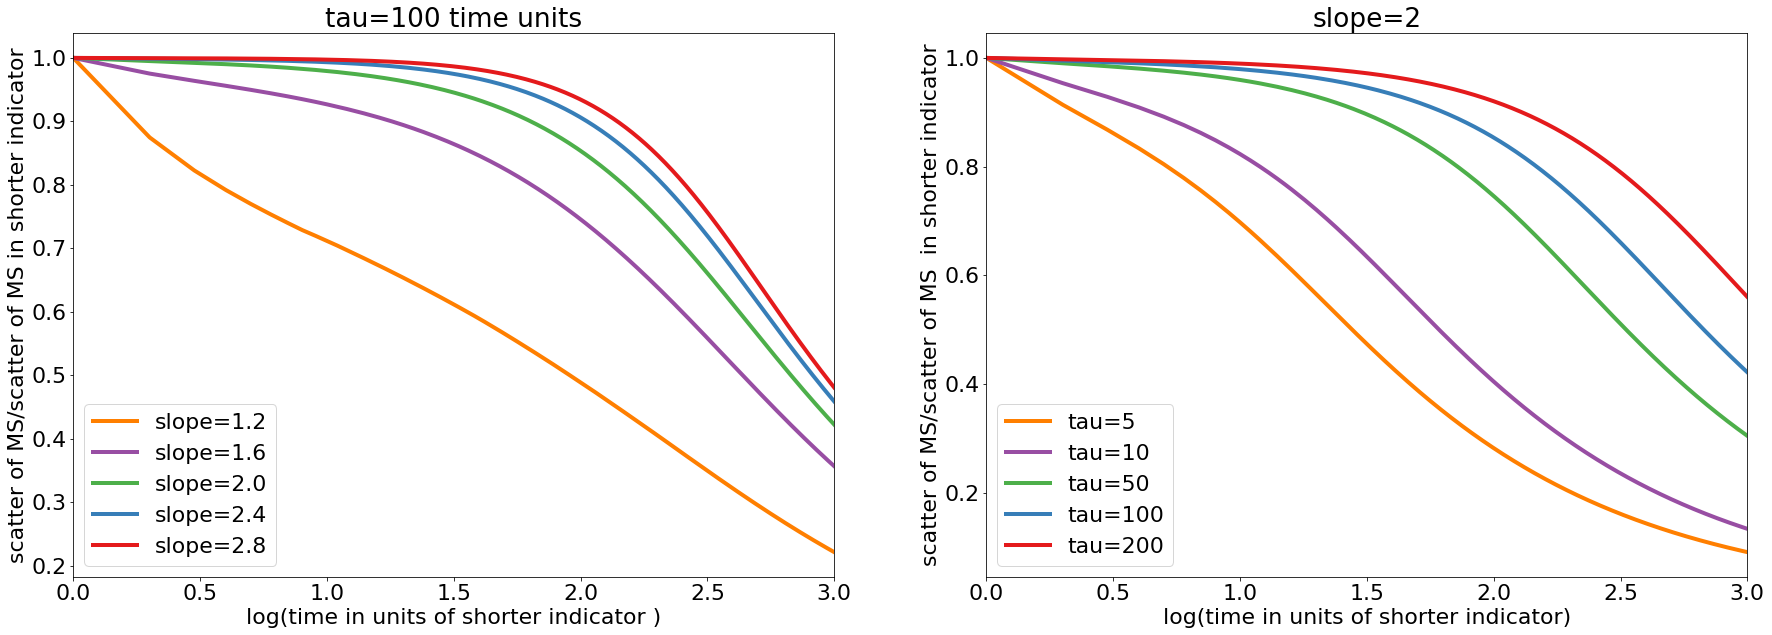

In [4]:
"""
Example showing how scatter depend on slope and tau 
"""
plot_slope=2
plot_tau=100


plt.figure(figsize=(30,10))

plt.subplot(121)

Scatter_Example1=get_scatter_MS(plot_tau,1.2)
Scatter_Example2=get_scatter_MS(plot_tau,1.6)
Scatter_Example3=get_scatter_MS(plot_tau,2)
Scatter_Example4=get_scatter_MS(plot_tau,2.4)
Scatter_Example5=get_scatter_MS(plot_tau,2.8)

plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4)
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='#4daf4a',label='slope=2.0',lw=4)
plt.plot(np.log10(Scatter_Example4[:,0]),Scatter_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4)
plt.plot(np.log10(Scatter_Example5[:,0]),Scatter_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4)

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator )')
plt.ylabel('scatter of MS/scatter of MS in shorter indicator')
plt.title('tau='+str(plot_tau)+' time units')
plt.legend(fontsize=22)



plt.subplot(122)
Scatter_Example1=get_scatter_MS(5,plot_slope)
Scatter_Example2=get_scatter_MS(10,plot_slope)
Scatter_Example3=get_scatter_MS(50,plot_slope)
Scatter_Example4=get_scatter_MS(100,plot_slope)
Scatter_Example5=get_scatter_MS(200,plot_slope)

plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='#984ea3',label='tau=10',lw=4)
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='#4daf4a',label='tau=50',lw=4)
plt.plot(np.log10(Scatter_Example4[:,0]),Scatter_Example4[:,1],color='#377eb8',label='tau=100',lw=4)
plt.plot(np.log10(Scatter_Example5[:,0]),Scatter_Example5[:,1],color='#e41a1c',label='tau=200',lw=4)

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('scatter of MS/scatter of MS  in shorter indicator')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## Mean relation between indicators at longer and shorter time scales

Given the measurment of the offset from the main sequence measured in a shorter time indicator (e.g., H_alpha),  offset from the main sequence of the same object measured by a longer time indicator (e.g., UV) will be given by relation:

$ \Delta SFR_{longer}=\Delta SFR_{shorter} \cdot \frac{1}{N} \sum^{N}_{j=1} ACF(j) $  

where N is numer of times than the longer time indicator is lager (longer) than the short time indicator. This can be "easily" seen once when we realize $\Delta  SFR_{shorter} (j) =\Delta  SFR_{shorter} (j^{'}) \cdot ACF(j-j^{'})   $ and combine with  $ \Delta SFR_{longer}= \sum^{N}_{j=1} \Delta SFR_{shorter}(j)$




For exact case of damped random walk where we know that $ACF(j)=\exp(-j/\tau)$, where $\tau$ is decorrelation time, we can evaluate the sum explicity to get: 

$\Delta SFR_{longer}=\Delta SFR_{shorter}  \left(- \frac{\exp(1/\tau)-\exp(-N/\tau)}{N(1- \exp(1/\tau))} \right) $

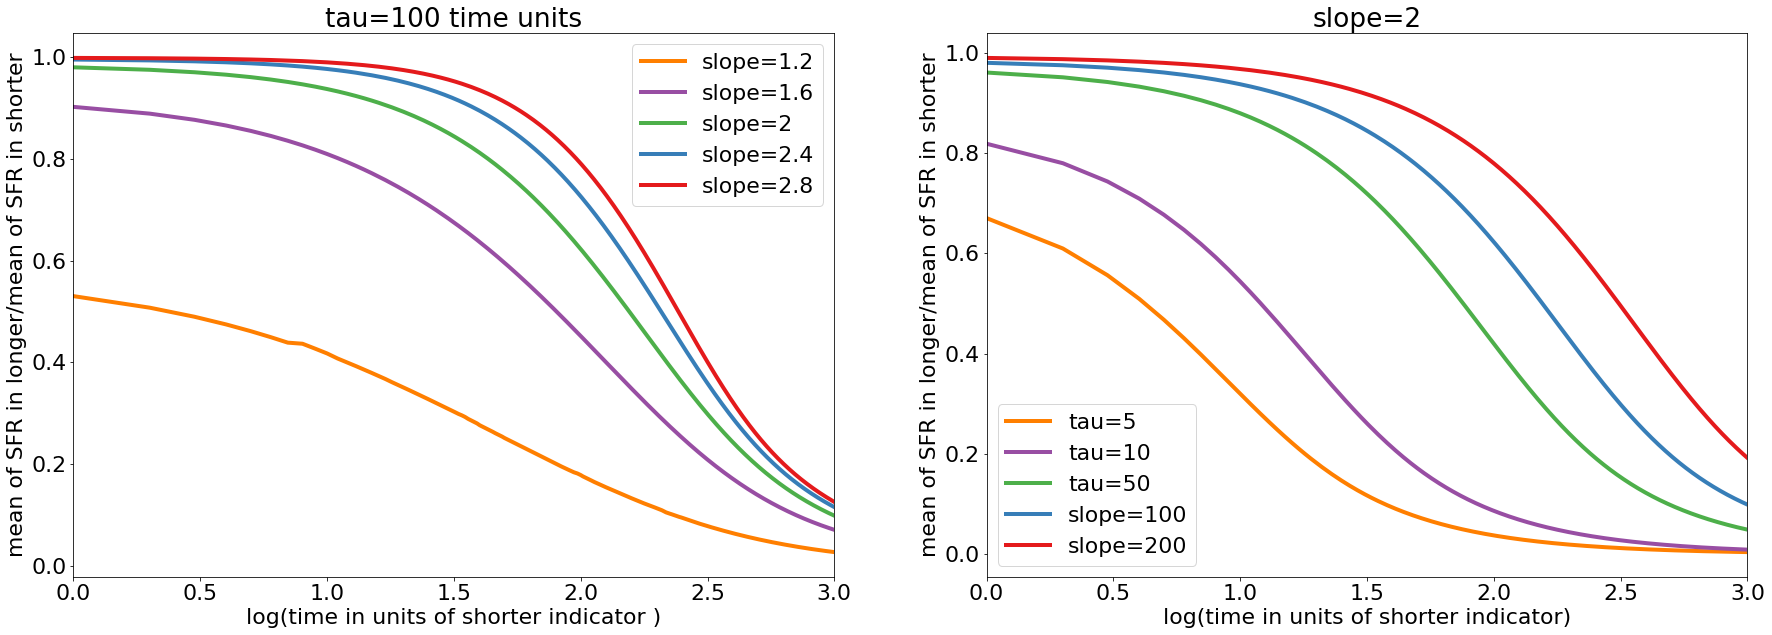

In [6]:
"""
Example showing how mean depend on slope and tau 
"""
plt.figure(figsize=(30,10))

plot_slope=2
plot_tau=100

plt.subplot(121)

Mean_Example1=get_mean_relation(plot_tau,1.2)
Mean_Example2=get_mean_relation(plot_tau,1.6)
Mean_Example3=get_mean_relation(plot_tau,2)
Mean_Example4=get_mean_relation(plot_tau,2.4)
Mean_Example5=get_mean_relation(plot_tau,2.8)

plt.plot(np.log10(Mean_Example1[:,0]),Mean_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(Mean_Example2[:,0]),Mean_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4,)
plt.plot(np.log10(Mean_Example3[:,0]),Mean_Example3[:,1],color='#4daf4a',label='slope=2',lw=4,)
plt.plot(np.log10(Mean_Example4[:,0]),Mean_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4,)
plt.plot(np.log10(Mean_Example5[:,0]),Mean_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4,)
#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator )')
plt.ylabel('mean of SFR in longer/mean of SFR in shorter')
plt.title('tau='+str(plot_tau)+' time units')
plt.legend(fontsize=22)


plt.subplot(122)
Mean_Example1=get_mean_relation(5,plot_slope)
Mean_Example2=get_mean_relation(10,plot_slope)
Mean_Example3=get_mean_relation(50,plot_slope)
Mean_Example4=get_mean_relation(100,plot_slope)
Mean_Example5=get_mean_relation(200,plot_slope)

plt.plot(np.log10(Mean_Example1[:,0]),Mean_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(Mean_Example2[:,0]),Mean_Example2[:,1],color='#984ea3',label='tau=10',lw=4,)
plt.plot(np.log10(Mean_Example3[:,0]),Mean_Example3[:,1],color='#4daf4a',label='tau=50',lw=4,)
plt.plot(np.log10(Mean_Example4[:,0]),Mean_Example4[:,1],color='#377eb8',label='slope=100',lw=4,)
plt.plot(np.log10(Mean_Example5[:,0]),Mean_Example5[:,1],color='#e41a1c',label='slope=200',lw=4,)

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('mean of SFR in longer/mean of SFR in shorter')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## error of Delta SFR_longer at given Delta SFR_shorter

There is also information in the size of the scatter in $\Delta SFR_{longer}$ at a given  $\Delta SFR_{shorter}$ and vice versa (this quantity is denoted by the size of the yellow 'error' bars in the example figures below). Problem with using this information is that:
    1. Very difficult to observe 
    2. depends on the size of the bins and 
    3. depends on how step the relation betweem SFR at longer and shorer time scale is

Given those problems and that this is very similar information which is encapsulated in measuring scatter of MS we do not use this information, but we give relation below:

$\sigma_{longer}|_{\mbox{given shorter}}=\frac{\sigma_{shorter}}{\sqrt{N}} \left( \sum^{N}_{j=1} \sum^{N}_{j^{'}=1} ACF(j-j^{'}) (1-ACF(j))^{1/2} (1-ACF(j^{'}))^{1/2} \right)^{1/2} $ 

This realation can note be simlified further as the relation for scatter in section 1.2 could, as the summand now is not a function of only $j-j^{'}$.

# Examples with simulated data

Below we show few example with generated SFR history curves and show that our theoretical predictions match what is seen in generated data. We use (very) losely $H_{\alpha}$ as a name shorter time indicator and UV as a name for longer time indicator.

In [148]:
from DELCgen import *

## With the same slope, different tau

In [149]:
# amplitude
A=1
#slope on the short time scales
a_low=2.0
#slope on the long time scales
a_high=0
# intercept/offset: adds constant to the final output
c=10

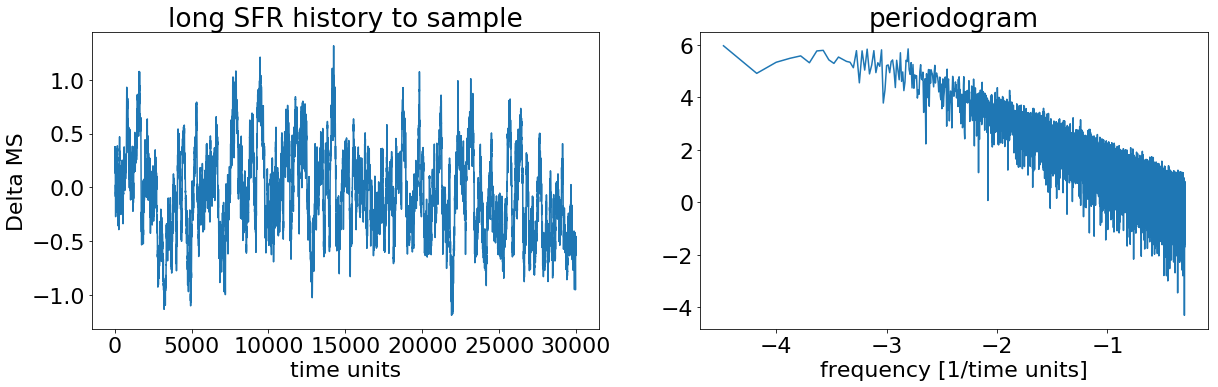

In [150]:
# keep RedNoiseL at least at 10, perhaps 5 if it gets really slow
# Keep aliasTbin=1 


#frequency of the break
v_bend_Example1=1.0/( 20*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example1,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
#Set scatter of the Main Sequence at 0.4 dex in this example
delc_flux_Example1=0.4*delc.flux

#frequency of the break
v_bend_Example2=1.0/(100*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example2,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example2=0.4*delc.flux

#frequency of the break
v_bend_Example3=1.0/( 200*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example3,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example3=0.4*delc.flux

# Plot showing created movement around Main Sequence and the periodogram 
plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(0.4*delc.flux)
plt.title('long SFR history to sample')
plt.xlabel('time units')
plt.ylabel('Delta MS')

plt.subplot(222)
plt.plot(np.log10(delc.periodogram[0]),np.log10(delc.periodogram[1]))
plt.title('periodogram')
plt.xlabel('frequency [1/time units]')

In [151]:
# We use here 'SFR_Halpha' as SFR measured on shorter time scale
# and 'SFR_UV' as SFR measured on longer time scale
# Tmax = answer to the question How much longer is 'SFR_UV' then 'SFR_Halpha'?
Tmax=100

#generate 'data'
res_Example1=[]
res_Example2=[]
res_Example3=[]
random_start_positions=np.random.randint(0,30000-Tmax,10000)
# for each example take 1. one SFR history position (SFR_Halpha = SFR_real) and 2. 100 adjecent points and average them (mimics SFR_UV)

delc_flux_Example1_convolved_decay_time1=np.log10(np.convolve(np.power(10,delc_flux_Example1),convolving_array1,'full'))[5000:len(delc_flux_Example1)]

#TO DO: replace this clumsy code with convolutions as in Section 3
for i in range(len(random_start_positions)):
    res_Example1.append([delc_flux_Example1[random_start_positions[i]+Tmax],np.mean(delc_flux_Example1[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example2.append([delc_flux_Example2[random_start_positions[i]+Tmax],np.mean(delc_flux_Example2[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example3.append([delc_flux_Example3[random_start_positions[i]+Tmax],np.mean(delc_flux_Example3[random_start_positions[i]:random_start_positions[i]+Tmax])])

    
    
    
res_Example1=np.array(res_Example1)    
res_Example2=np.array(res_Example2)    
res_Example3=np.array(res_Example3)  

In [152]:
# estimate mean relation from the data between 'SFR_UV' and 'SFR_Halpha'

SFR_SFR_Example1=[]
SFR_SFR_Example2=[]
SFR_SFR_Example3=[]
for i in np.arange(-1,1,0.05):
    res_Example1_bin=res_Example1[np.all([res_Example1[:,0]<i+0.05, res_Example1[:,0]>i],axis=0)]
    SFR_SFR_Example1.append([np.mean(res_Example1_bin[:,0]),np.mean(res_Example1_bin[:,1]),np.std(res_Example1_bin[:,1])])
    res_Example2_bin=res_Example2[np.all([res_Example2[:,0]<i+0.05, res_Example2[:,0]>i],axis=0)]
    SFR_SFR_Example2.append([np.mean(res_Example2_bin[:,0]),np.mean(res_Example2_bin[:,1]),np.std(res_Example2_bin[:,1])])
    res_Example3_bin=res_Example3[np.all([res_Example3[:,0]<i+0.01, res_Example3[:,0]>i],axis=0)]
    SFR_SFR_Example3.append([np.mean(res_Example3_bin[:,0]),np.mean(res_Example3_bin[:,1]),np.std(res_Example3_bin[:,1])])
    
SFR_SFR_Example1=np.array(SFR_SFR_Example1)
SFR_SFR_Example2=np.array(SFR_SFR_Example2)
SFR_SFR_Example3=np.array(SFR_SFR_Example3)

In [153]:
# theoretical mean relation between 'SFR_UV' and 'SFR_Halpha'

tau_Example1=(1/v_bend_Example1)/(2*np.pi)
SFR_UV_Theoretical_Example1=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example1.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau_Example1,a_low)[Tmax-1][1]])
SFR_UV_Theoretical_Example1=np.array(SFR_UV_Theoretical_Example1)

tau_Example2=(1/v_bend_Example2)/(2*np.pi)
SFR_UV_Theoretical_Example2=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example2.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau_Example2,a_low)[Tmax-1][1]])
SFR_UV_Theoretical_Example2=np.array(SFR_UV_Theoretical_Example2)

tau_Example3=(1/v_bend_Example3)/(2*np.pi)
SFR_UV_Theoretical_Example3=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example3.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau_Example3,a_low)[Tmax-1][1]])
SFR_UV_Theoretical_Example3=np.array(SFR_UV_Theoretical_Example3)

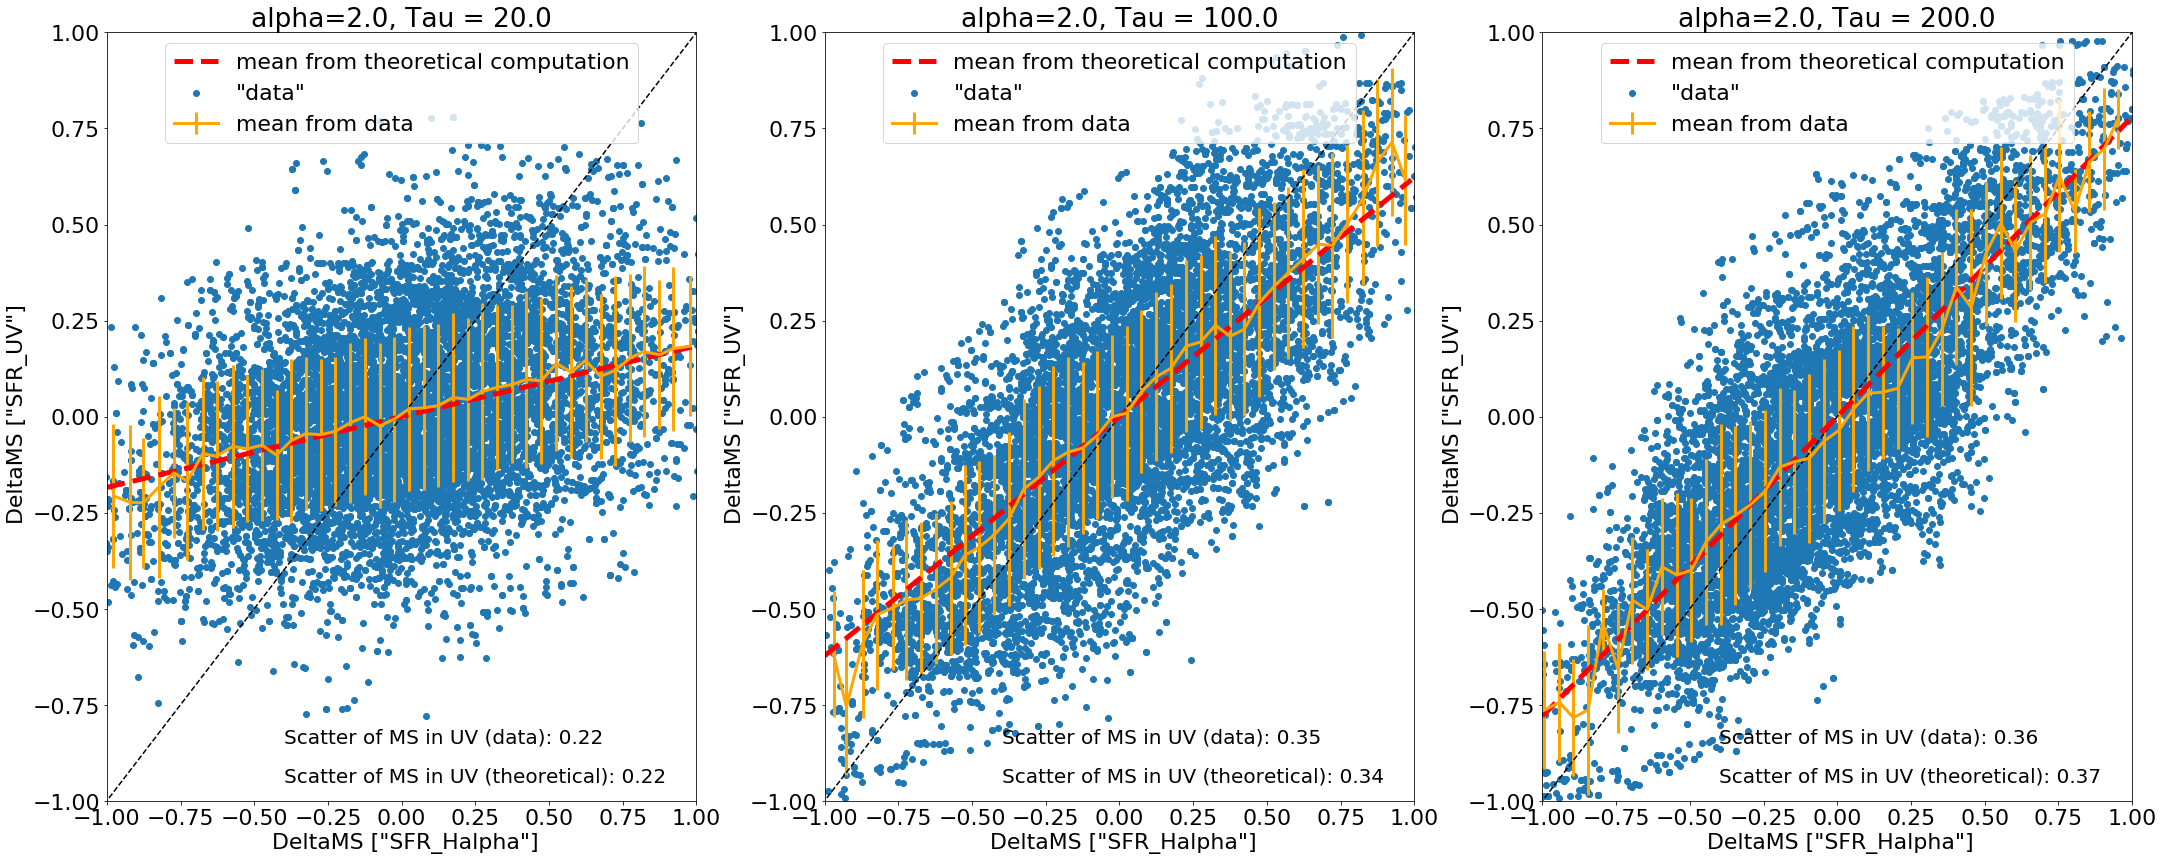

In [154]:
plt.figure(figsize=(30,12))

plt.subplot(1,3,1)
plt.scatter(res_Example1[:,0],res_Example1[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example1[:,0],SFR_SFR_Example1[:,1],yerr=SFR_SFR_Example1[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example1[:,0],SFR_UV_Theoretical_Example1[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example1))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example1[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example1,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,2)
plt.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


plt.subplot(1,3,3)
plt.scatter(res_Example3[:,0],res_Example3[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example3[:,0],SFR_SFR_Example3[:,1],yerr=SFR_SFR_Example3[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example3[:,0],SFR_UV_Theoretical_Example3[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example3))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example3[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example3,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [161]:
print("Example 1 - sigma_MS (SFR_Halpha): "+str(np.std(res_Example1[:,1])))
print("Example 1 - sigma_MS (SFR_UV): "+str(np.std(res_Example1[:,0])))

print("Example 1 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha): "+str(np.std(res_Example1[:,1])/np.std(res_Example1[:,0])))

print("")
print("Example 2 - sigma_MS (SFR_Halpha): "+str(np.std(res_Example2[:,1])))
print("Example 2 - sigma_MS (SFR_UV): "+str(np.std(res_Example2[:,0])))

print("Example 2 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)"+str(np.std(res_Example2[:,1])/np.std(res_Example2[:,0])))

print("")

print("Example 3 - sigma_MS (SFR_Halpha): "+str(np.std(res_Example3[:,1])))
print("Example 3 - sigma_MS (SFR_UV): "+str(np.std(res_Example3[:,0])))

print("Example 3 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)"+str(np.std(res_Example3[:,1])/np.std(res_Example3[:,0])))

print("")

Example 1 - sigma_MS (SFR_Halpha): 0.224108858152
Example 1 - sigma_MS (SFR_UV): 0.403429009412
Example 1 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha): 0.555510022639

Example 2 - sigma_MS (SFR_Halpha): 0.352082207557
Example 2 - sigma_MS (SFR_Halpha): 0.402954943469
Example 2 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)0.873750808281

Example 3 - sigma_MS (SFR_Halpha): 0.357766782096
Example 3 - sigma_MS (SFR_Halpha): 0.394783927785
Example 3 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)0.906234415628



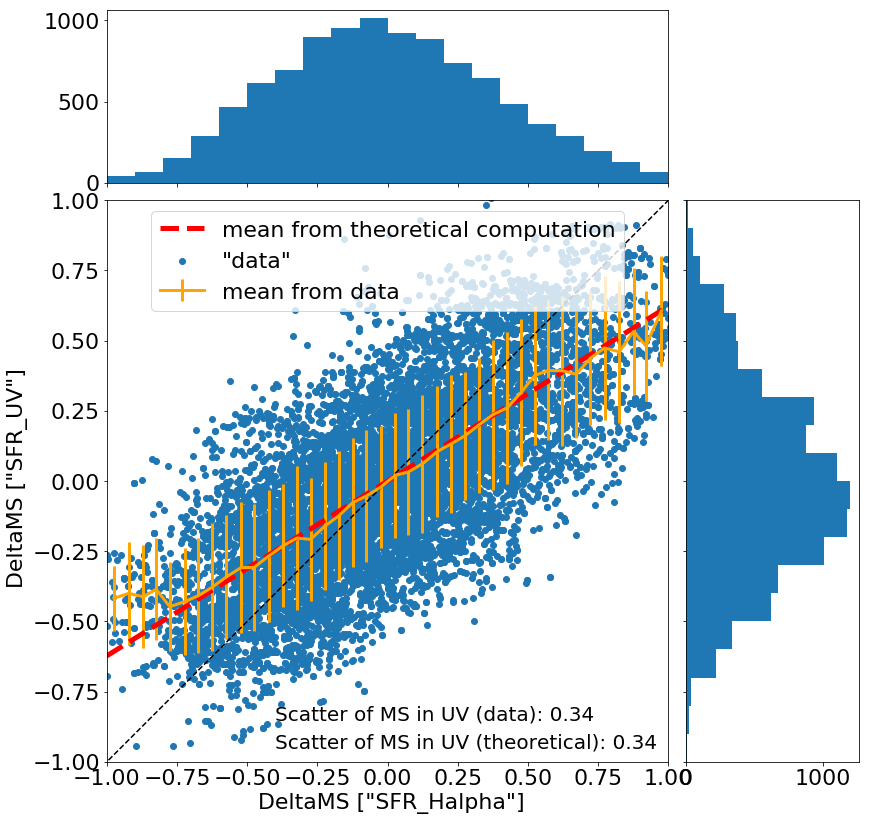

In [58]:
#single plot showing explicity difference in scatter for the middle panel in the Figure above

from matplotlib.ticker import NullFormatter

plt.figure(figsize=(12,12))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(NullFormatter() )
axHisty.yaxis.set_major_formatter(NullFormatter() )

x=res_Example2[:,0]
y=res_Example2[:,1]

axScatter.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
axScatter.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')

axScatter.set_xlabel(' DeltaMS ["SFR_Halpha"]')
axScatter.set_ylabel(' DeltaMS ["SFR_UV"]')
axScatter.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
axScatter.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
axScatter.legend(loc='upper center')
#axScatter.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
axScatter.set_xlim([-1,1])
axScatter.set_ylim(-1,1)
axScatter.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
axScatter.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


# now determine nice limits by hand:
binwidth = 0.1
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth


bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()


#plt.xlabel(' DeltaMS ["SFR_Halpha"]')
#plt.ylabel(' DeltaMS ["SFR_UV"]')
#plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
#plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
#plt.legend(loc='9')
#plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
#plt.xlim(-1,1)
#plt.ylim(-1,1)
#plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
#plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

## With the same tau, different slope

In [89]:
# amplitude
A=1
#slope on the long time scales
a_high=0
#frequency of the break
v_bend=1.0/(100*2*np.pi)
# intercept/offset: adds constant to the final output
c=10

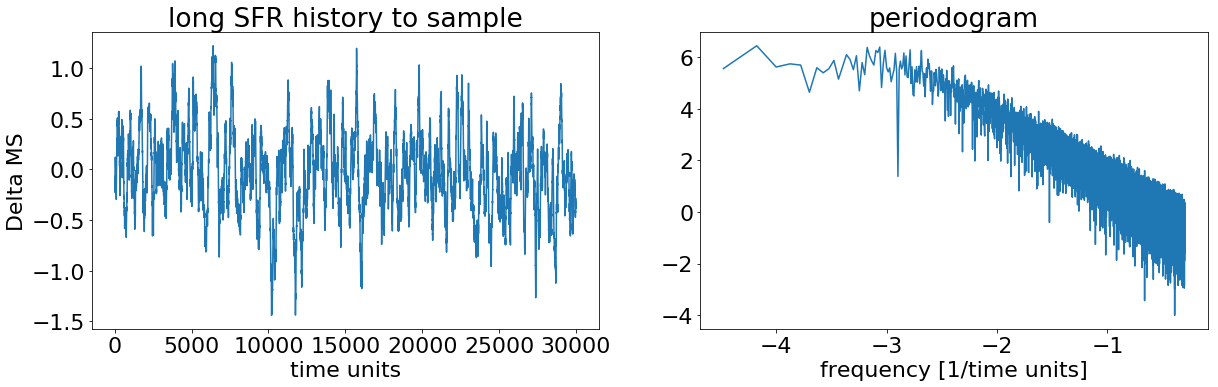

In [90]:
# keep RedNoiseL at least at 10, perhaps 5 if it gets really slow
# Keep aliasTbin=1 

#slope on the short time scales
a_low_Example1=1.5
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend,a_low_Example1,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
#Set scatter of the Main Sequence at 0.4 dex in this example
delc_flux_Example1=0.4*delc.flux

#frequency of the break
a_low_Example2=2
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend,a_low_Example2,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example2=0.4*delc.flux

#frequency of the break
a_low_Example3=2.5
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend,a_low_Example3,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example3=0.4*delc.flux

# Plot showing created movement around Main Sequence and the periodogram 
plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(0.4*delc.flux)
plt.title('long SFR history to sample')
plt.xlabel('time units')
plt.ylabel('Delta MS')

plt.subplot(222)
plt.plot(np.log10(delc.periodogram[0]),np.log10(delc.periodogram[1]))
plt.title('periodogram')
plt.xlabel('frequency [1/time units]')

In [91]:
# We use here 'SFR_Halpha' as SFR measured on shorter time scale
# and 'SFR_UV' as SFR measured on longer time scale
# Tmax = answer to the question: How much longer is 'SFR_UV' then 'SFR_Halpha'?
Tmax=100

#generate 'data'
res_Example1=[]
res_Example2=[]
res_Example3=[]
random_start_positions=np.random.randint(0,30000-Tmax,10000)
for i in range(len(random_start_positions)):
    res_Example1.append([delc_flux_Example1[random_start_positions[i]+Tmax],np.mean(delc_flux_Example1[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example2.append([delc_flux_Example2[random_start_positions[i]+Tmax],np.mean(delc_flux_Example2[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example3.append([delc_flux_Example3[random_start_positions[i]+Tmax],np.mean(delc_flux_Example3[random_start_positions[i]:random_start_positions[i]+Tmax])])
   
res_Example1=np.array(res_Example1)    
res_Example2=np.array(res_Example2)    
res_Example3=np.array(res_Example3)  

In [92]:
# estimate mean relation between 'SFR_UV' and 'SFR_Halpha' from the data

SFR_SFR_Example1=[]
SFR_SFR_Example2=[]
SFR_SFR_Example3=[]
for i in np.arange(-1,1,0.05):
    res_Example1_bin=res_Example1[np.all([res_Example1[:,0]<i+0.05, res_Example1[:,0]>i],axis=0)]
    SFR_SFR_Example1.append([np.mean(res_Example1_bin[:,0]),np.mean(res_Example1_bin[:,1]),np.std(res_Example1_bin[:,1])])
    res_Example2_bin=res_Example2[np.all([res_Example2[:,0]<i+0.05, res_Example2[:,0]>i],axis=0)]
    SFR_SFR_Example2.append([np.mean(res_Example2_bin[:,0]),np.mean(res_Example2_bin[:,1]),np.std(res_Example2_bin[:,1])])
    res_Example3_bin=res_Example3[np.all([res_Example3[:,0]<i+0.05, res_Example3[:,0]>i],axis=0)]
    SFR_SFR_Example3.append([np.mean(res_Example3_bin[:,0]),np.mean(res_Example3_bin[:,1]),np.std(res_Example3_bin[:,1])])
    
SFR_SFR_Example1=np.array(SFR_SFR_Example1)
SFR_SFR_Example2=np.array(SFR_SFR_Example2)
SFR_SFR_Example3=np.array(SFR_SFR_Example3)

In [93]:
# theoretical mean relation between 'SFR_UV' and 'SFR_Halpha'

tau=(1/v_bend)/(2*np.pi)

SFR_UV_Theoretical_Example1=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example1.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau,a_low_Example1)[Tmax-1][1]])
SFR_UV_Theoretical_Example1=np.array(SFR_UV_Theoretical_Example1)


SFR_UV_Theoretical_Example2=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example2.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau,a_low_Example2)[Tmax-1][1]])
SFR_UV_Theoretical_Example2=np.array(SFR_UV_Theoretical_Example2)


SFR_UV_Theoretical_Example3=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example3.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau,a_low_Example3)[Tmax-1][1]])
SFR_UV_Theoretical_Example3=np.array(SFR_UV_Theoretical_Example3)

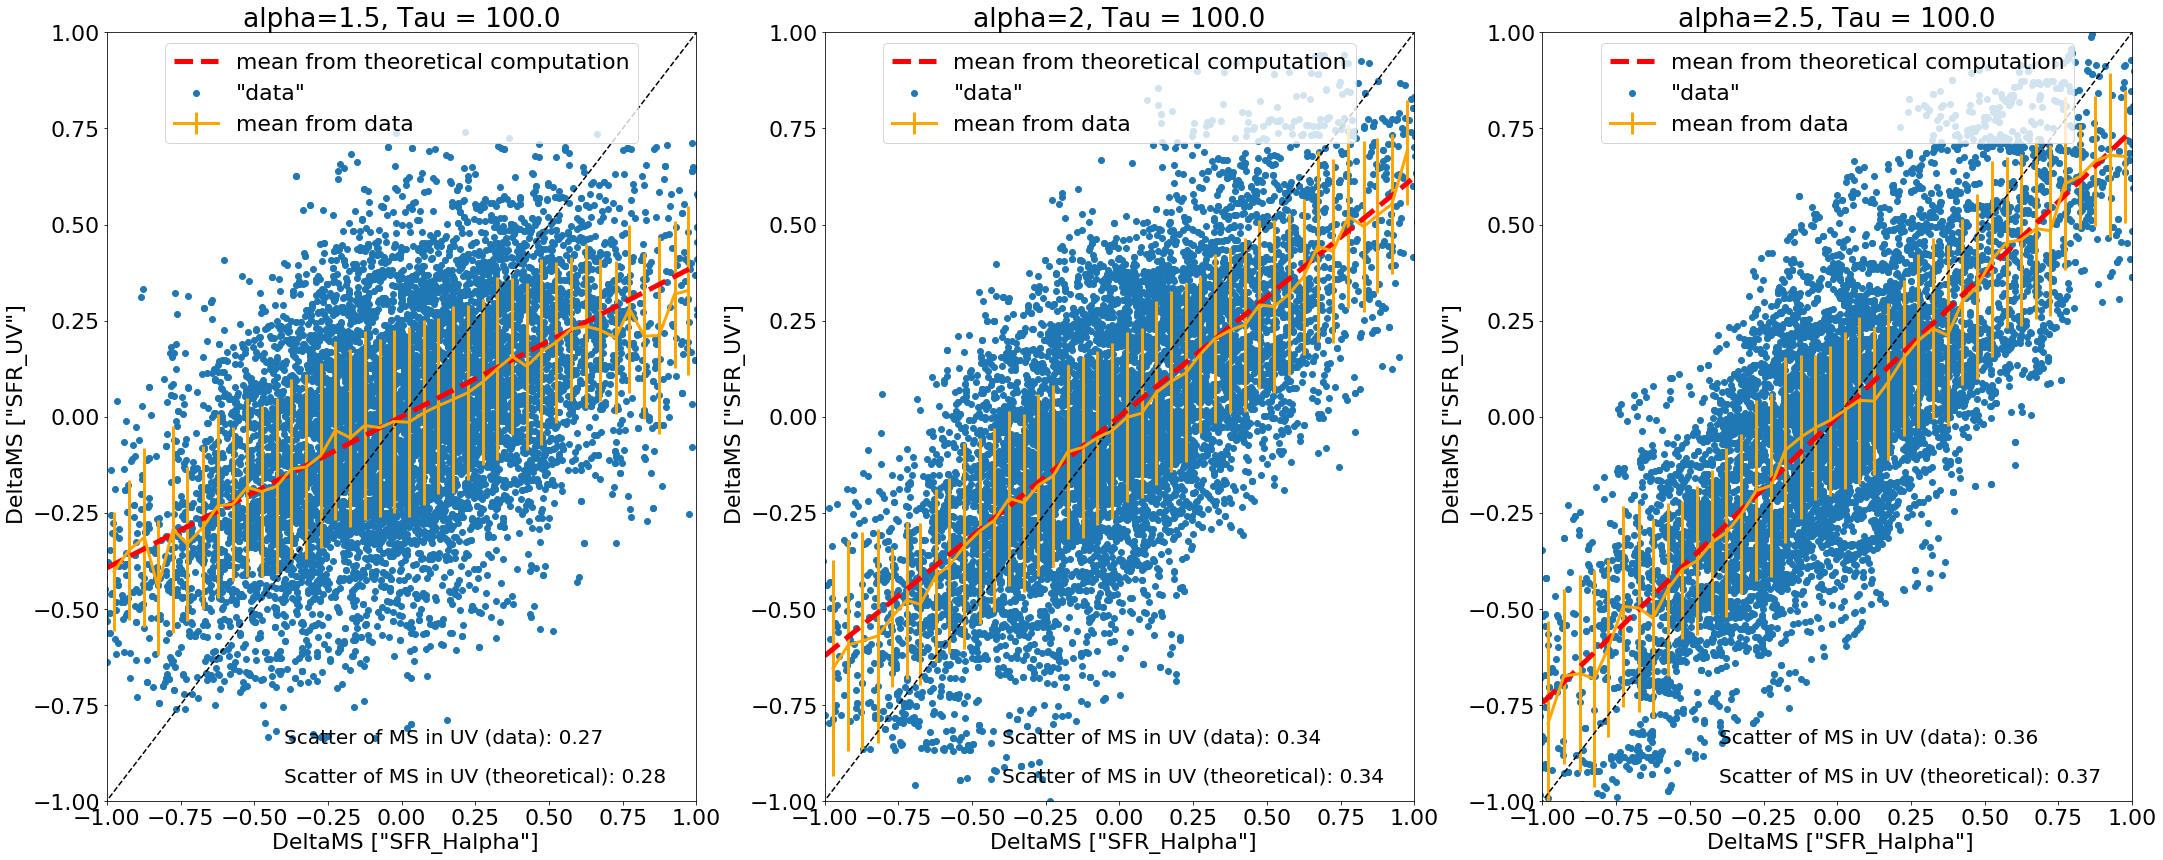

In [94]:
plt.figure(figsize=(30,12))

plt.subplot(1,3,1)
plt.scatter(res_Example1[:,0],res_Example1[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example1[:,0],SFR_SFR_Example1[:,1],yerr=SFR_SFR_Example1[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example1[:,0],SFR_UV_Theoretical_Example1[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc=9)
plt.title("alpha="+str(a_low_Example1)+", Tau = "+str(tau))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example1[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau,a_low_Example1)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,2)
plt.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc=9)
plt.title("alpha="+str(a_low_Example2)+", Tau = "+str(tau))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau,a_low_Example2)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,3)
plt.scatter(res_Example3[:,0],res_Example3[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example3[:,0],SFR_SFR_Example3[:,1],yerr=SFR_SFR_Example3[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example3[:,0],SFR_UV_Theoretical_Example3[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc=9)
plt.title("alpha="+str(a_low_Example3)+", Tau = "+str(tau))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example3[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau,a_low_Example3)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

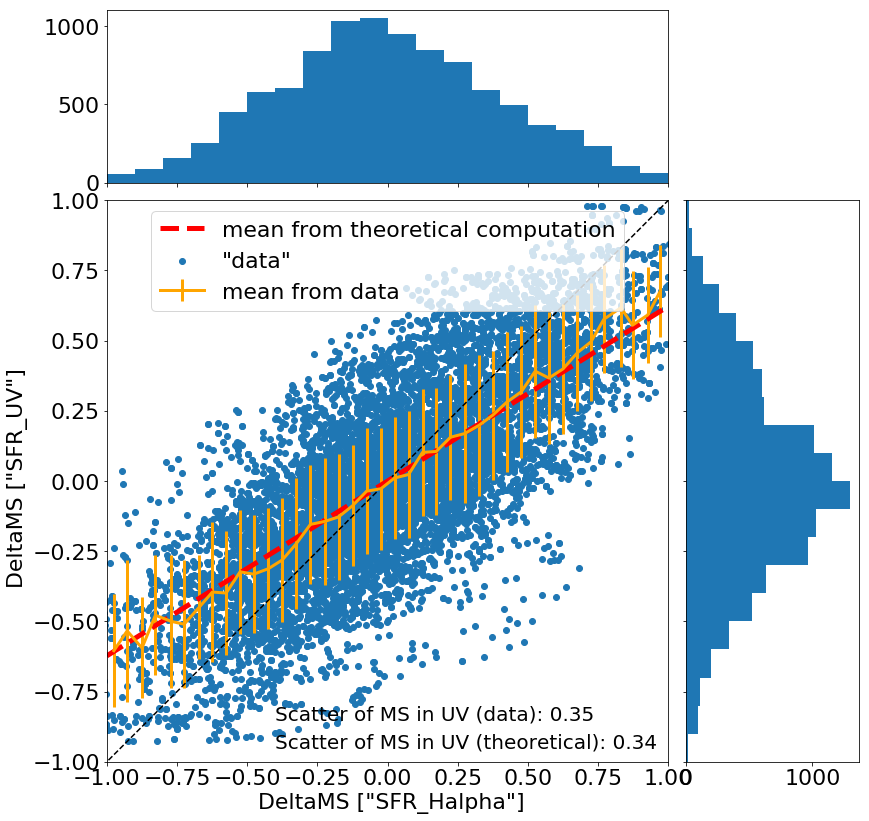

In [115]:
#single plot showing explicity difference in scatter for the middle panel in the Figure above

from matplotlib.ticker import NullFormatter

plt.figure(figsize=(12,12))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(NullFormatter() )
axHisty.yaxis.set_major_formatter(NullFormatter() )

x=res_Example2[:,0]
y=res_Example2[:,1]

axScatter.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
axScatter.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')

axScatter.set_xlabel(' DeltaMS ["SFR_Halpha"]')
axScatter.set_ylabel(' DeltaMS ["SFR_UV"]')
axScatter.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
axScatter.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
axScatter.legend(loc='upper center')
#axScatter.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
axScatter.set_xlim([-1,1])
axScatter.set_ylim(-1,1)
axScatter.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
axScatter.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


# now determine nice limits by hand:
binwidth = 0.1
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth


bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()


# Determining slope and time-scale from the data (simple example)

In [109]:
from DELCgen import *

In this section we want to see how well we can recover the result from the data. In this example we assume that response functions of our SFR indicators are step functions, i.e., actual SFR influences SFR measurment equivally until some time, Tmax, after which the response function drops to zero. 

## generating some data with known parameters

Below we generate some data with known decorellation time (100 t.u.) and slope (2) to see how well we can recover the results. This uses the same code as in the Section above to generate the data. We assume  that we measured data with 3 indicators and that: 1. the total response time for the shortest indicator (very loosely called SFR_Halpha) is 1 t.u., 2. and the total response time for the longer indicator (very loosely called SFR_UV) is 20.t.u. and 3. the total response time for the longest indicator (very loosely called SFR_u) is 100 .t.u.

In [117]:
# amplitude
A=1
#slope on the short time scales
a_low=2.0
#slope on the long time scales
a_high=0
# intercept/offset: adds constant to the final output
c=10

#create actual SFR
v_bend_Example2=1.0/(100*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example2,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example2=0.4*delc.flux

#generate observed SFR in H_alpha (in this case it is the same as the actual SFR)
Tmax=1
convolving_array1=np.ones(Tmax)/Tmax
delc_flux_Example2_convolved_decay_time1=np.log10(np.convolve(np.power(10,delc_flux_Example2),convolving_array1,'full'))[5000:len(delc_flux_Example2)]

#generate observed SFR in UV
Tmax=20
convolving_array2=np.ones(Tmax)/Tmax
delc_flux_Example2_convolved_decay_time2=np.log10(np.convolve(np.power(10,delc_flux_Example2),convolving_array2,'full'))[5000:len(delc_flux_Example2)]

#generate observed SFR in u
Tmax=100
convolving_array3=np.ones(Tmax)/Tmax
delc_flux_Example2_convolved_decay_time3=np.log10(np.convolve(np.power(10,delc_flux_Example2),convolving_array3,'full'))[5000:len(delc_flux_Example2)]


Estimate the scatter of the main sequence in Halpha and UV, find the ratio and the error 

In [118]:
res_Example2_1_2=[]
random_start_positions=np.random.randint(0,len(delc_flux_Example2_convolved_decay_time2),10000)
for i in range(len(random_start_positions)):
    res_Example2_1_2.append([delc_flux_Example2_convolved_decay_time1[random_start_positions[i]],delc_flux_Example2_convolved_decay_time2[random_start_positions[i]]])
res_Example2_1_2=np.array(res_Example2_1_2)    

#bootstraping to estimate uncertainty 
res=[]
for i in range(100):
    res.append(np.std(bootstrap_resample(res_Example2_1_2[:,1]))/np.std(bootstrap_resample(res_Example2_1_2[:,0])))
    
print("Example with Tmax=20 t.u. - sigma_MS (SFR_Halpha): "+str(np.std(res_Example2_1_2[:,0])))
print("Example with Tmax=20 t.u. - sigma_MS (SFR_UV): "+str(np.std(res_Example2_1_2[:,1])))

print("Example with Tmax=20 t.u. - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)"+str(np.mean(res))+"+-"+str(np.std(res)))    

Example with Tmax=20 t.u. - sigma_MS (SFR_Halpha): 0.399641361916
Example with Tmax=20 t.u. - sigma_MS (SFR_UV): 0.386881250059
Example with Tmax=20 t.u. - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)0.967613002618+-0.0100137722483



Estimate the scatter of the main sequence in Halpha and u, find the ratio and the error 

In [119]:
#we are overloading res_Example2 here,but we do not use this variable ever again
res_Example2_1_3=[]
random_start_positions=np.random.randint(0,len(delc_flux_Example2_convolved_decay_time3),10000)
for i in range(len(random_start_positions)):
    res_Example2_1_3.append([delc_flux_Example2_convolved_decay_time1[random_start_positions[i]],delc_flux_Example2_convolved_decay_time3[random_start_positions[i]]])
res_Example2_1_3=np.array(res_Example2_1_3)    

#bootstraping to estimate uncertainty 
res=[]
for i in range(100):
    res.append(np.std(bootstrap_resample(res_Example2_1_3[:,1]))/np.std(bootstrap_resample(res_Example2_1_3[:,0])))
    
print("Example with Tmax=100 t.u - sigma_MS (SFR_Halpha): "+str(np.std(res_Example2_1_3[:,0])))
print("Example with Tmax=100 t.u - sigma_MS (SFR_u): "+str(np.std(res_Example2_1_3[:,1])))

print("Example with Tmax=100 t.u - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_Halpha)"+str(np.mean(res))+"+-"+str(np.std(res)))

Example with Tmax=100 t.u - sigma_MS (SFR_Halpha): 0.402156517828
Example with Tmax=100 t.u - sigma_MS (SFR_u): 0.340307992836
Example with Tmax=100 t.u - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_Halpha)0.846849266752+-0.0106519437662


## estimating paramterers from the data (scatter)

MS width supplied in the first step have relativly corse resolution, which is due to the fact that they are span 3-dimensional space (slope, time of decorellation, time-span of longer indicator in units of shorter indicator). We 'know' what the time-spans of our indicators is and we first create finer 2D grid of slopes and decorellation time, at a given time span of a longer indicator ( in this example, 20 and 100 times longer than the shorest indicator). 

In [49]:
t_longer_1=20
MS_slope_at_given_t_longer_1_interpolation = create_MS_scatter_at_given_t_interpolation(t_longer_1)

t_longer_2=100
MS_slope_at_given_t_longer_2_interpolation = create_MS_scatter_at_given_t_interpolation(t_longer_2)

100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


We implement scatter measurments and their errors estimated in the subsection above...

In [54]:
Measurment_Of_Scatter_Ratio_1=0.97
err_Measurment_Of_Scatter_Ratio_1=0.01

Measurment_Of_Scatter_Ratio_2=0.85
err_Measurment_Of_Scatter_Ratio_2=0.008

tau_fine,slope_fine,Number_of_sigmas_deviation_reshaped_1,best_solution_1=create_Number_of_sigmas(MS_slope_at_given_t_longer_1_interpolation,Measurment_Of_Scatter_Ratio_1,err_Measurment_Of_Scatter_Ratio_1)
tau_fine,slope_fine,Number_of_sigmas_deviation_reshaped_2,best_solution_2=create_Number_of_sigmas(MS_slope_at_given_t_longer_2_interpolation,Measurment_Of_Scatter_Ratio_2,err_Measurment_Of_Scatter_Ratio_2)

100%|██████████| 180/180 [00:11<00:00, 15.66it/s]


Below we plot 1-sigma contours in the tau-slope plane. Dashed line shows exact solution, i.e., the solution if the error on the measurment of scatter was vanishingly small. With black dashed lines we show the parameter values used to generate the data. 

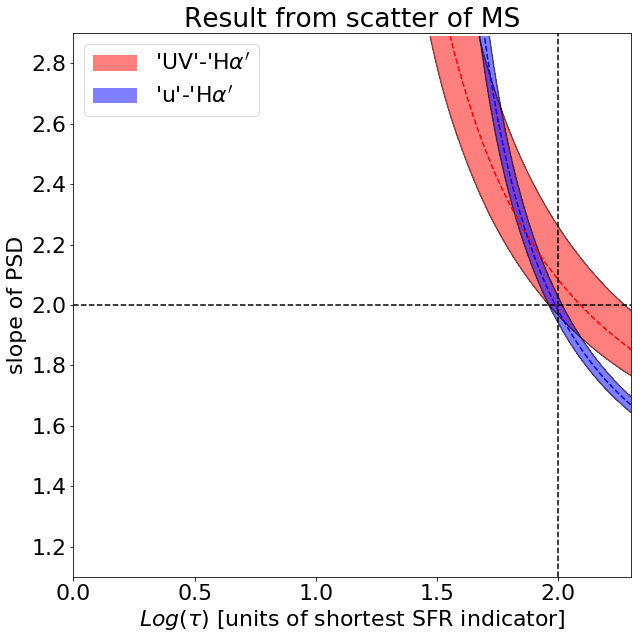

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
CS = ax.contour(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_1,cmap=plt.cm.bone,levels=[1,50],alpha=0.5)
CS2 = ax.contour(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_2,cmap=plt.cm.bone,levels=[1,50],alpha=0.5)
CS3 = ax.contourf(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_1, [0,1],colors=('r'),alpha=0.5)
CS4 = ax.contourf(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_2, [0,1],colors=('b'),alpha=0.5)

plt.plot(np.log10(best_solution_1[:,1]),best_solution_1[:,0],'r',linestyle='dashed')
plt.plot(np.log10(best_solution_2[:,1]),best_solution_2[:,0],'b',linestyle='dashed')

h1,_ = CS3.legend_elements()
h2,_ = CS4.legend_elements()
ax.legend([h1[0], h2[0]], ['\'UV\'-\'H$\\alpha\'$', '\'u\'-\'H$\\alpha\'$'])

# Recast levels to new class
CS.levels = [1,1.5]
CS3.levels = [1,1.5]
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \sigma %'
else:
    fmt = '%r $\sigma$'

plt.plot(np.ones(100)*2,'black',linestyle='dashed')
plt.axvline(x=np.log10(100),color='black',linestyle='dashed')    
    
#ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
#ax.clabel(CS3, CS3.levels, inline=True, fmt=fmt, fontsize=10)
ax.set_ylim(1.1,2.9)
plt.xlim(np.min(np.log10(tau_fine)),np.max(np.log10(tau_fine)))
#ax.legend()
ax.set_title('Result from scatter of MS')
ax.set_xlabel('$Log(\\tau)$ [units of shortest SFR indicator]')
ax.set_ylabel('slope of PSD')

## estimate parameters from the data (means)

In [162]:
# estimate mean relation from the data between 'SFR_UV' and 'SFR_Halpha'

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(res_Example2_1_2[:,0],res_Example2_1_2[:,1])


"""
SFR_SFR_Example2=[]
for i in np.arange(-1,1,0.05):
    res_Example2_1_2_bin=res_Example2_1_2[np.all([res_Example2_1_2[:,0]<i+0.05, res_Example2_1_2[:,0]>i],axis=0)]
    SFR_SFR_Example2.append([np.mean(res_Example2_1_2_bin[:,0]),np.mean(res_Example2_1_2_bin[:,1]),np.std(res_Example2_1_2_bin[:,1])])
    
# 1. SFR_Halpha, 2. SFR_UV, 3. scatter of SFR_UV at given SFR_Halpha
SFR_SFR_Example2=np.array(SFR_SFR_Example2)
"""
Measurment_Of_Offset_Ratio_1=slope
err_Measurment_Of_Offset_Ratio_1=std_err
print(slope)
print(std_err)

slope, intercept, r_value, p_value, std_err = stats.linregress(res_Example2_1_3[:,0],res_Example2_1_3[:,1])

print(slope)
print(std_err)

Measurment_Of_Offset_Ratio_2=slope
err_Measurment_Of_Offset_Ratio_2=std_err

0.907033074113
0.00338342339617
0.614440849217
0.0058189161181


In [163]:
t_longer_1=20
offset_slope_at_given_t_longer_1_interpolation = create_offset_slope_at_given_t_interpolation(t_longer_1)

t_longer_2=100
offset_slope_at_given_t_longer_2_interpolation = create_offset_slope_at_given_t_interpolation(t_longer_2)

100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


In [168]:
Measurment_Of_Scatter_Ratio_1=0.907
err_Measurment_Of_Scatter_Ratio_1=0.0033

Measurment_Of_Scatter_Ratio_2=0.614
err_Measurment_Of_Scatter_Ratio_2=0.0058

tau_fine,slope_fine,Number_of_sigmas_offset_reshaped_1,best_solution_1=create_Number_of_sigmas_offset(offset_slope_at_given_t_longer_1_interpolation,Measurment_Of_Offset_Ratio_1,err_Measurment_Of_Offset_Ratio_1)
tau_fine,slope_fine,Number_of_sigmas_offset_reshaped_2,best_solution_2=create_Number_of_sigmas_offset(offset_slope_at_given_t_longer_2_interpolation,Measurment_Of_Offset_Ratio_2,err_Measurment_Of_Offset_Ratio_2)

100%|██████████| 180/180 [00:12<00:00, 14.87it/s]


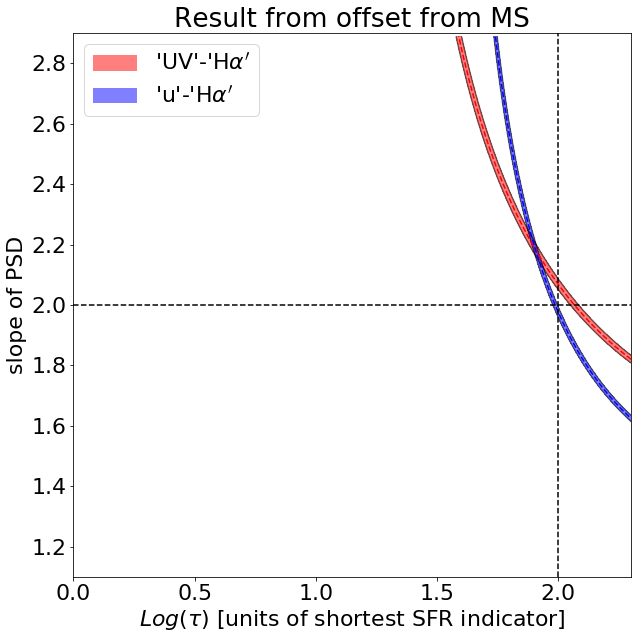

In [170]:
fig, ax = plt.subplots(figsize=(10, 10))
CS = ax.contour(np.log10(tau_fine), slope_fine, Number_of_sigmas_offset_reshaped_1,cmap=plt.cm.bone,levels=[1,50],alpha=0.5)
CS2 = ax.contour(np.log10(tau_fine), slope_fine, Number_of_sigmas_offset_reshaped_2,cmap=plt.cm.bone,levels=[1,50],alpha=0.5)
CS3 = ax.contourf(np.log10(tau_fine), slope_fine, Number_of_sigmas_offset_reshaped_1, [0,1],colors=('r'),alpha=0.5)
CS4 = ax.contourf(np.log10(tau_fine), slope_fine, Number_of_sigmas_offset_reshaped_2, [0,1],colors=('b'),alpha=0.5)

plt.plot(np.log10(best_solution_1[:,1]),best_solution_1[:,0],'r',linestyle='dashed')
plt.plot(np.log10(best_solution_2[:,1]),best_solution_2[:,0],'b',linestyle='dashed')

h1,_ = CS3.legend_elements()
h2,_ = CS4.legend_elements()
ax.legend([h1[0], h2[0]], ['\'UV\'-\'H$\\alpha\'$', '\'u\'-\'H$\\alpha\'$'])

# Recast levels to new class
CS.levels = [1,1.5]
CS3.levels = [1,1.5]
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \sigma %'
else:
    fmt = '%r $\sigma$'

plt.plot(np.ones(100)*2,'black',linestyle='dashed')
plt.axvline(x=np.log10(100),color='black',linestyle='dashed')    
    
#ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
#ax.clabel(CS3, CS3.levels, inline=True, fmt=fmt, fontsize=10)
ax.set_ylim(1.1,2.9)
plt.xlim(np.min(np.log10(tau_fine)),np.max(np.log10(tau_fine)))
#ax.legend()
ax.set_title('Result from offset from MS')
ax.set_xlabel('$Log(\\tau)$ [units of shortest SFR indicator]')
ax.set_ylabel('slope of PSD')

# Example with generated data with exponential SFR responses

In [14]:
from DELCgen import *

In this section we again want to see how well we can recover the result from the data. In this example we assume more realistic response functions of our SFR indicators, and we assume that they are well approximated by exponentially declining function with a given decay time. (internal note - hopefully also see if it is better to use 'real' respones times or empirically motivated response times).

## Generating data with the same slope, but different tau

We generate several histories, as in Section 2, with same slopes but different decorellation times

In [57]:
# amplitude
A=1
#slope on the short time scales
a_low=2.0
#slope on the long time scales
a_high=0
# intercept/offset: adds constant to the final output
c=10

We generate one very long SFR history which is same, per ergodic theorem, as sampling many shorter SFR histories. 

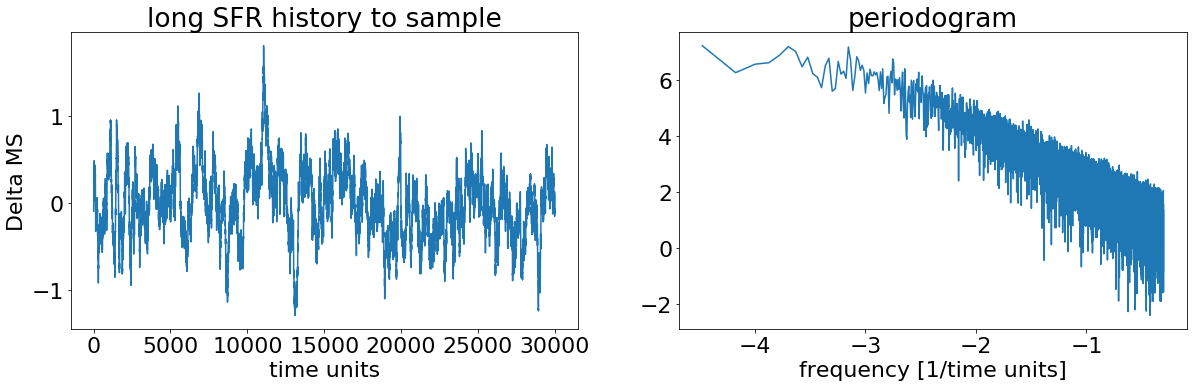

In [58]:
v_bend_Example1=1.0/( 20*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example1,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
#Set scatter of the Main Sequence at 0.4 dex in this example
delc_flux_Example1=0.4*delc.flux

v_bend_Example2=1.0/(100*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example2,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example2=0.4*delc.flux

v_bend_Example3=1.0/( 200*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example3,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example3=0.4*delc.flux

# Plot showing created movement around Main Sequence and the periodogram 
plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(0.4*delc.flux)
plt.title('long SFR history to sample')
plt.xlabel('time units')
plt.ylabel('Delta MS')

plt.subplot(222)
plt.plot(np.log10(delc.periodogram[0]),np.log10(delc.periodogram[1]))
plt.title('periodogram')
plt.xlabel('frequency [1/time units]')

Here we construct SFR respones measured with three indicators. We assume that the response is an exponential function and we bin in unit of 1 time unit. We also cut the front edges of the measured SFR histories to avoid edge effects due to the fact that our histories are not infinite. 

In [59]:
#mimics Halpha with decay time of 3 Myr, assuming that t.u.=0.25 Myr
decay_time1=12

convolving_array1=(np.exp(-np.array(range(delc_flux_Example1.shape[0]))/decay_time1)-np.exp(-(1+np.array(range(delc_flux_Example1.shape[0]))/decay_time1)))
convolving_array1=convolving_array1/np.sum(convolving_array1)
convolving_array1=convolving_array1[convolving_array1>0]

delc_flux_Example1_convolved_decay_time1=np.log10(np.convolve(np.power(10,delc_flux_Example1),convolving_array1,'full'))[5000:len(delc_flux_Example1)]
delc_flux_Example2_convolved_decay_time1=np.log10(np.convolve(np.power(10,delc_flux_Example2),convolving_array1,'full'))[5000:len(delc_flux_Example2)]
delc_flux_Example3_convolved_decay_time1=np.log10(np.convolve(np.power(10,delc_flux_Example3),convolving_array1,'full'))[5000:len(delc_flux_Example3)]

delc_flux_Example1_convolved_decay_time1_sample=np.random.choice(delc_flux_Example1_convolved_decay_time1,1000)
delc_flux_Example2_convolved_decay_time1_sample=np.random.choice(delc_flux_Example2_convolved_decay_time1,1000)
delc_flux_Example3_convolved_decay_time1_sample=np.random.choice(delc_flux_Example3_convolved_decay_time1,1000)

#mimics FUV with decay time of 6 Myr, assuming that t.u.=0.25 Myr
decay_time2=24

convolving_array2=(np.exp(-np.array(range(delc_flux_Example1.shape[0]))/decay_time2)-np.exp(-(1+np.array(range(delc_flux_Example1.shape[0]))/decay_time2)))
convolving_array2=convolving_array2/np.sum(convolving_array2)
convolving_array2=convolving_array2[convolving_array2>0]


delc_flux_Example1_convolved_decay_time2=np.log10(np.convolve(np.power(10,delc_flux_Example1),convolving_array2,'full'))[5000:len(delc_flux_Example1)]
delc_flux_Example2_convolved_decay_time2=np.log10(np.convolve(np.power(10,delc_flux_Example2),convolving_array2,'full'))[5000:len(delc_flux_Example2)]
delc_flux_Example3_convolved_decay_time2=np.log10(np.convolve(np.power(10,delc_flux_Example3),convolving_array2,'full'))[5000:len(delc_flux_Example3)]

delc_flux_Example1_convolved_decay_time2_sample=np.random.choice(delc_flux_Example1_convolved_decay_time2,1000)
delc_flux_Example2_convolved_decay_time2_sample=np.random.choice(delc_flux_Example2_convolved_decay_time2,1000)
delc_flux_Example3_convolved_decay_time2_sample=np.random.choice(delc_flux_Example3_convolved_decay_time2,1000)

#mimics u-band poorly, with decay time of 25 Myr, assuming that t.u.=0.25 Myr
decay_time3=100

convolving_array3=(np.exp(-np.array(range(delc_flux_Example1.shape[0]))/decay_time3)-np.exp(-(1+np.array(range(delc_flux_Example1.shape[0]))/decay_time3)))
convolving_array3=convolving_array3/np.sum(convolving_array3)
convolving_array3=convolving_array3[convolving_array3>0]

delc_flux_Example1_convolved_decay_time3=np.log10(np.convolve(np.power(10,delc_flux_Example1),convolving_array3,'full'))[5000:len(delc_flux_Example1)]
delc_flux_Example2_convolved_decay_time3=np.log10(np.convolve(np.power(10,delc_flux_Example2),convolving_array3,'full'))[5000:len(delc_flux_Example2)]
delc_flux_Example3_convolved_decay_time3=np.log10(np.convolve(np.power(10,delc_flux_Example3),convolving_array3,'full'))[5000:len(delc_flux_Example3)]

delc_flux_Example1_convolved_decay_time3_sample=np.random.choice(delc_flux_Example1_convolved_decay_time3,1000)
delc_flux_Example2_convolved_decay_time3_sample=np.random.choice(delc_flux_Example2_convolved_decay_time3,1000)
delc_flux_Example3_convolved_decay_time3_sample=np.random.choice(delc_flux_Example3_convolved_decay_time3,1000)

/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10


In [60]:
tau_Example1=(1/v_bend_Example1)/(2*np.pi)
tau_Example2=(1/v_bend_Example2)/(2*np.pi)
tau_Example3=(1/v_bend_Example3)/(2*np.pi)

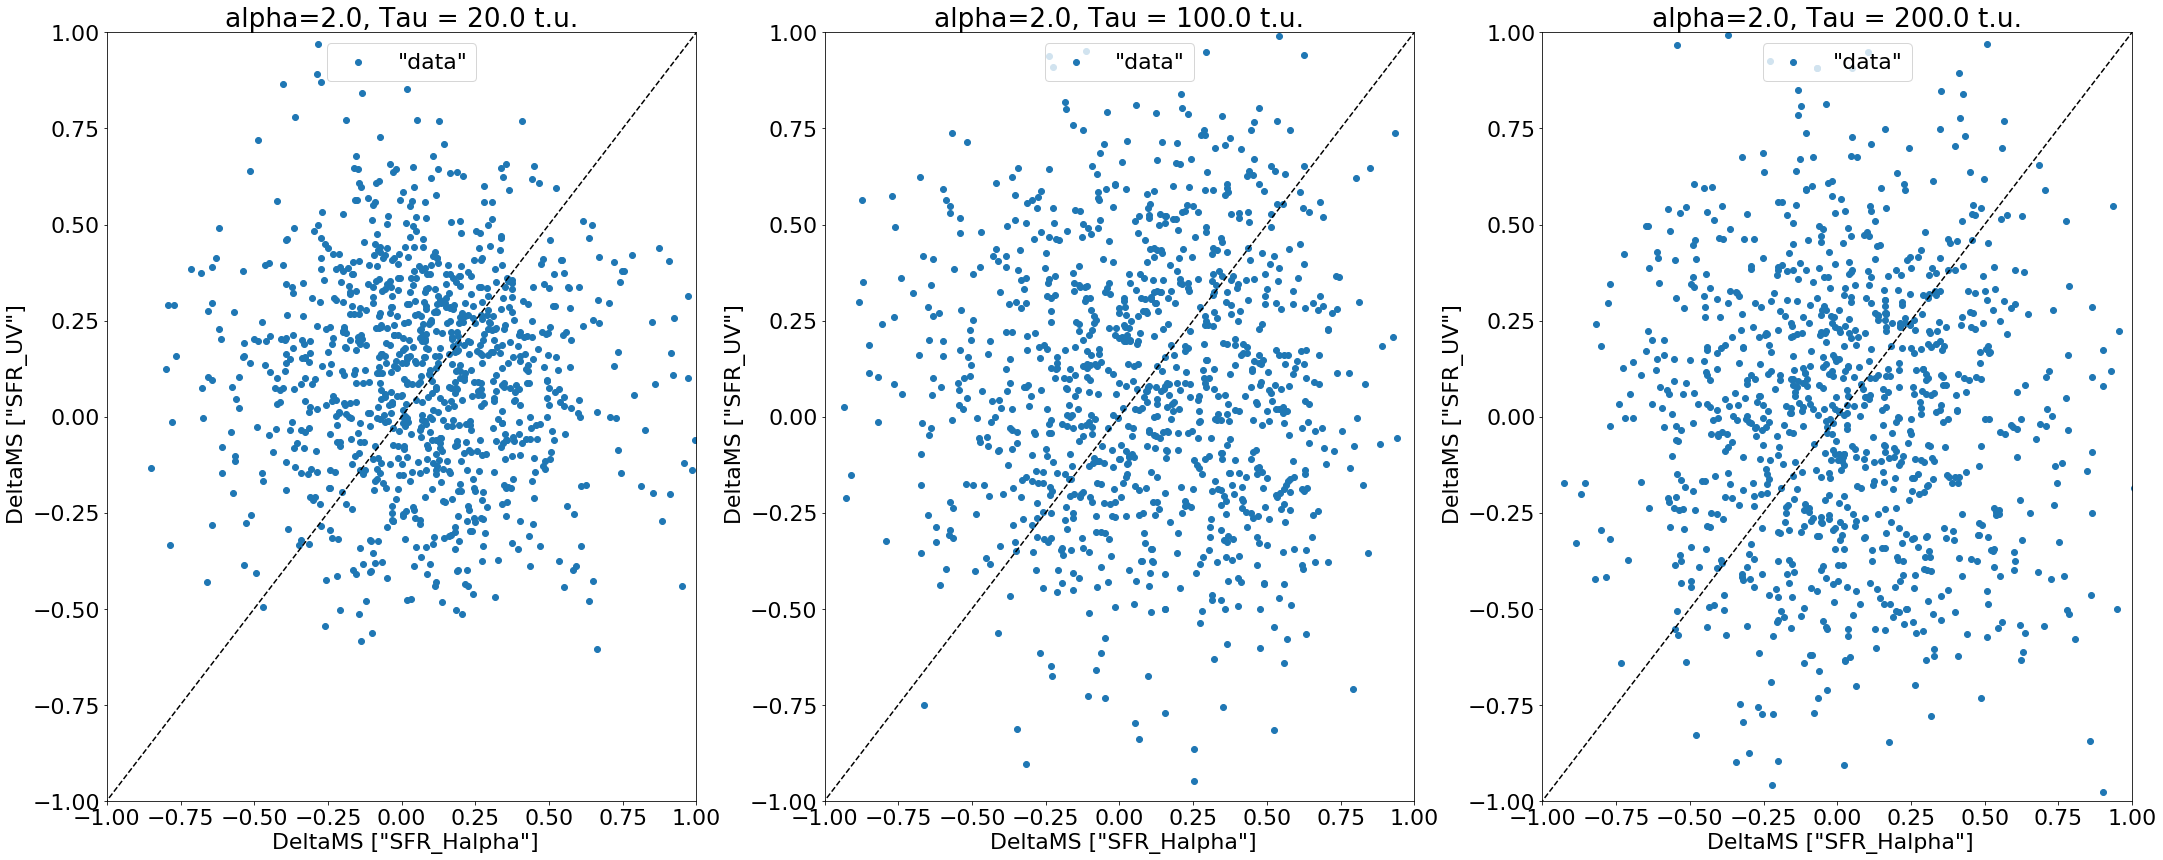

In [61]:
plt.figure(figsize=(30,12))

plt.subplot(1,3,1)
plt.scatter(delc_flux_Example1_convolved_decay_time1_sample,delc_flux_Example1_convolved_decay_time2_sample,label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example1)+' t.u.')
plt.xlim(-1,1)
plt.ylim(-1,1)
#plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example1[:,1]),2),{'color': 'black', 'fontsize': 20})
#plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example1,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,2)
plt.scatter(delc_flux_Example2_convolved_decay_time1_sample,delc_flux_Example2_convolved_decay_time2_sample,label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2)+' t.u.')
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.subplot(1,3,3)
plt.scatter(delc_flux_Example3_convolved_decay_time1_sample,delc_flux_Example3_convolved_decay_time2_sample,label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example3)+' t.u.')
plt.xlim(-1,1)
plt.ylim(-1,1)


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [125]:
print("Example 1 - sigma_MS (SFR_Halpha): "+str(np.std(delc_flux_Example1_convolved_decay_time1_sample))+'+-'+str(np.std(delc_flux_Example1_convolved_decay_time1_sample)/np.sqrt(2*len(delc_flux_Example1_convolved_decay_time1_sample)-2)))
print("Example 1 - sigma_MS (SFR_UV): "+str(np.std(delc_flux_Example1_convolved_decay_time2_sample))+'+-'+str(np.std(delc_flux_Example1_convolved_decay_time2_sample)/np.sqrt(2*len(delc_flux_Example1_convolved_decay_time2_sample)-2)))
print("Example 1 - sigma_MS (SFR_u): "+str(np.std(delc_flux_Example1_convolved_decay_time3_sample))+'+-'+str(np.std(delc_flux_Example1_convolved_decay_time3_sample)/np.sqrt(2*len(delc_flux_Example1_convolved_decay_time3_sample)-2)))

print("Example 1 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha): "+str(np.std(delc_flux_Example1_convolved_decay_time2_sample)/np.std(delc_flux_Example1_convolved_decay_time1_sample)))
print("Example 1 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_Halpha): "+str(np.std(delc_flux_Example1_convolved_decay_time3_sample)/np.std(delc_flux_Example1_convolved_decay_time1_sample)))
print("Example 1 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_UV): "+str(np.std(delc_flux_Example1_convolved_decay_time3_sample)/np.std(delc_flux_Example1_convolved_decay_time2_sample)))

print("")
print("Example 2 - sigma_MS (SFR_Halpha): "+str(np.std(delc_flux_Example2_convolved_decay_time1_sample)))
print("Example 2 - sigma_MS (SFR_Halpha): "+str(np.std(delc_flux_Example2_convolved_decay_time2_sample)))
print("Example 2 - sigma_MS (SFR_u): "+str(np.std(delc_flux_Example2_convolved_decay_time3_sample)))

print("Example 2 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)"+str(np.std(delc_flux_Example2_convolved_decay_time2_sample)/np.std(delc_flux_Example2_convolved_decay_time1_sample)))
print("Example 2 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_Halpha): "+str(np.std(delc_flux_Example2_convolved_decay_time3_sample)/np.std(delc_flux_Example2_convolved_decay_time1_sample)))
print("Example 2 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_UV): "+str(np.std(delc_flux_Example2_convolved_decay_time3_sample)/np.std(delc_flux_Example2_convolved_decay_time2_sample)))

print("")

print("Example 3 - sigma_MS (SFR_Halpha): "+str(np.std(delc_flux_Example3_convolved_decay_time1_sample)))
print("Example 3 - sigma_MS (SFR_Halpha): "+str(np.std(delc_flux_Example3_convolved_decay_time2_sample)))
print("Example 3 - sigma_MS (SFR_u): "+str(np.std(delc_flux_Example3_convolved_decay_time3_sample)))

print("Example 3 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)"+str(np.std(delc_flux_Example3_convolved_decay_time2_sample)/np.std(delc_flux_Example3_convolved_decay_time1_sample)))
print("Example 3 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_Halpha): "+str(np.std(delc_flux_Example3_convolved_decay_time3_sample)/np.std(delc_flux_Example3_convolved_decay_time1_sample)))
print("Example 3 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_UV): "+str(np.std(delc_flux_Example3_convolved_decay_time3_sample)/np.std(delc_flux_Example3_convolved_decay_time2_sample)))

print("")

Example 1 - sigma_MS (SFR_Halpha): 0.317168452763+-0.00709565091983
Example 1 - sigma_MS (SFR_UV): 0.259273224087+-0.00580042647671
Example 1 - sigma_MS (SFR_u): 0.156785322469+-0.00350758061812
Example 1 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha): 0.81746220921
Example 1 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_Halpha): 0.494328238205
Example 1 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_UV): 0.604710814317

Example 2 - sigma_MS (SFR_Halpha): 0.365654556402
Example 2 - sigma_MS (SFR_Halpha): 0.344265501138
Example 2 - sigma_MS (SFR_u): 0.260756847073
Example 2 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)0.941504748432
Example 2 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_Halpha): 0.713123472708
Example 2 - Ratio of sigma_MS (SFR_u)/sigma_MS (SFR_UV): 0.757429501972

Example 3 - sigma_MS (SFR_Halpha): 0.386428769646
Example 3 - sigma_MS (SFR_Halpha): 0.38777798916
Example 3 - sigma_MS (SFR_u): 0.342253294847
Example 3 - Ratio of sigma_MS (SFR_UV)/sigma_MS (SFR_Halpha)1.00349

## Using the result above and 'infer' the corect paramters 

In [11]:
# I should really make a module out of this

In [65]:
T_response_time_1=decay_time1*2
T_response_time_2=decay_time2*2
T_response_time_3=decay_time3*2

T_response_time_2_1=T_response_time_2/T_response_time_1
T_response_time_3_1=T_response_time_3/T_response_time_1

print("Time scale of the UV indicator is "+str(T_response_time_2_1)+" longer than the Halpha indicator")
print("Time scale of the u indicator is "+str(T_response_time_3_1)+" longer than the Halpha indicator")

Time scale of the UV indicator is 2.0 longer than the Halpha indicator
Time scale of the u indicator is 8.33333333333 longer than the Halpha indicator


As above, we now run a finer grid of tau and slopes, at a given response time

In [128]:
slope=slope[slope>1]

MS_slope_at_given_t_response=[]
for plot_slope in tqdm(slope):
    for plot_tau in tau: 
        MS_slope_at_given_t_response.append([plot_tau,plot_slope,get_scatter_MS(plot_tau,plot_slope,None,T_response_time_2_1)[1]])
        
MS_slope_at_given_t_response_2_1=np.array(MS_slope_at_given_t_response)[:,2]      
MS_slope_at_given_t_response_2_1=MS_slope_at_given_t_response_2_1.reshape(19,29)
       
MS_slope_at_given_t_response_2_1_interpolation = interpolate.interp2d(tau, slope, MS_slope_at_given_t_response_2_1, kind='cubic')


MS_slope_at_given_t_response=[]
for plot_slope in tqdm(slope):
    for plot_tau in tau: 
        MS_slope_at_given_t_response.append([plot_tau,plot_slope,get_scatter_MS(plot_tau,plot_slope,None,T_response_time_3_1)[1]])
        
MS_slope_at_given_t_response_3_1=np.array(MS_slope_at_given_t_response)[:,2]      
MS_slope_at_given_t_response_3_1=MS_slope_at_given_t_response_3_1.reshape(19,29)
       
MS_slope_at_given_t_response_3_1_interpolation = interpolate.interp2d(tau, slope, MS_slope_at_given_t_response_3_1, kind='cubic')


100%|██████████| 19/19 [00:28<00:00,  1.47s/it]


In [129]:
slope_fine=np.arange(1.1,2.9,0.01)
tau_fine=np.arange(1,200,0.1)

In [130]:
# lets work with example 2
Measurment_Of_Scatter_Ratio_2_1=0.94
# I did not compute this error, just a random number for the calculation
err_Measurment_Of_Scatter_Ratio_2_1=0.02

Number_of_sigmas_deviation_2_1=[]
for plot_slope in tqdm(slope_fine):
    for plot_tau in tau_fine: 
        Number_of_sigmas_deviation_2_1.append(abs((MS_slope_at_given_t_response_2_1_interpolation(plot_tau,plot_slope)-Measurment_Of_Scatter_Ratio_2_1)/err_Measurment_Of_Scatter_Ratio_2_1))
        
Number_of_sigmas_deviation_2_1=np.array(Number_of_sigmas_deviation_2_1)
Number_of_sigmas_deviation_2_1=Number_of_sigmas_deviation_2_1.reshape(len(slope_fine),len(tau_fine))



# lets work with example 2
Measurment_Of_Scatter_Ratio_3_1=0.71
# I did not compute this error, just a random number for the calculation
err_Measurment_Of_Scatter_Ratio_3_1=0.02

Number_of_sigmas_deviation_3_1=[]
for plot_slope in tqdm(slope_fine):
    for plot_tau in tau_fine: 
        Number_of_sigmas_deviation_3_1.append(abs((MS_slope_at_given_t_response_3_1_interpolation(plot_tau,plot_slope)-Measurment_Of_Scatter_Ratio_3_1)/err_Measurment_Of_Scatter_Ratio_3_1))
        
Number_of_sigmas_deviation_3_1=np.array(Number_of_sigmas_deviation_3_1)
Number_of_sigmas_deviation_3_1=Number_of_sigmas_deviation_3_1.reshape(len(slope_fine),len(tau_fine))




100%|██████████| 180/180 [00:11<00:00, 15.07it/s]


In [131]:
Number_of_sigmas_deviation_reshaped_2_1=np.copy(Number_of_sigmas_deviation_2_1)
Number_of_sigmas_deviation_reshaped_2_1=Number_of_sigmas_deviation_2_1.reshape(len(slope_fine),len(tau_fine))

Number_of_sigmas_deviation_reshaped_3_1=np.copy(Number_of_sigmas_deviation_3_1)
Number_of_sigmas_deviation_reshaped_3_1=Number_of_sigmas_deviation_3_1.reshape(len(slope_fine),len(tau_fine))

In [132]:
best_solution_2_1=[]
for i in range(len(Number_of_sigmas_deviation_reshaped_2_1)):
    best_solution_2_1.append([slope_fine[i],tau_fine[np.argmin(Number_of_sigmas_deviation_reshaped_2_1[i])],Number_of_sigmas_deviation_reshaped_2_1[i][np.argmin(Number_of_sigmas_deviation_reshaped_2_1[i])]])
    
best_solution_2_1=np.array(best_solution_2_1)
best_solution_2_1=best_solution_2_1[best_solution_2_1[:,2]<0.1]


best_solution_3_1=[]
for i in range(len(Number_of_sigmas_deviation_reshaped_3_1)):
    best_solution_3_1.append([slope_fine[i],tau_fine[np.argmin(Number_of_sigmas_deviation_reshaped_3_1[i])],Number_of_sigmas_deviation_reshaped_3_1[i][np.argmin(Number_of_sigmas_deviation_reshaped_3_1[i])]])
    
best_solution_3_1=np.array(best_solution_3_1)
best_solution_3_1=best_solution_3_1[best_solution_3_1[:,2]<0.1]


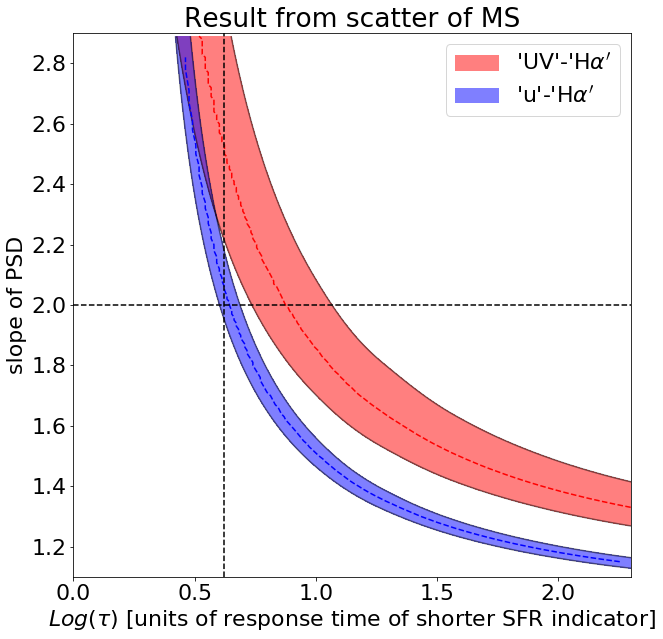

In [134]:
# Basic contour plot
fig, ax = plt.subplots(figsize=(10, 10))
CS = ax.contour(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_2_1,cmap=plt.cm.bone,levels=[1,500],alpha=0.5)
CS2 = ax.contour(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_3_1,cmap=plt.cm.bone,levels=[1,500],alpha=0.5)
CS3 = ax.contourf(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_2_1, [0,1],colors=('r'),alpha=0.5)
CS4 = ax.contourf(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_3_1, [0,1],colors=('b'),alpha=0.5)

plt.plot(np.log10(best_solution_2_1[:,1]),best_solution_2_1[:,0],'r',linestyle='dashed')
plt.plot(np.log10(best_solution_3_1[:,1]),best_solution_3_1[:,0],'b',linestyle='dashed')
plt.plot(np.ones(100)*2,'black',linestyle='dashed')
plt.axvline(x=np.log10(tau_Example2/T_response_time_1),color='black',linestyle='dashed')

h1,_ = CS3.legend_elements()
h2,_ = CS4.legend_elements()
ax.legend([h1[0], h2[0]], ['\'UV\'-\'H$\\alpha\'$', '\'u\'-\'H$\\alpha\'$'])

# Recast levels to new class
CS.levels = [1,1.5]
CS3.levels = [1,1.5]
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \sigma %'
else:
    fmt = '%r $\sigma$'

#ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
#ax.clabel(CS3, CS3.levels, inline=True, fmt=fmt, fontsize=10)
ax.set_ylim(1.1,2.9)
ax.set_xlim(np.min(np.log10(tau_fine)),np.max(np.log10(tau_fine)))
#ax.legend()
ax.set_title('Result from scatter of MS')
ax.set_xlabel('$Log(\\tau)$ [units of response time of shortest SFR indicator]')
ax.set_ylabel('slope of PSD')

# Future work  - relations between longer and shorter timescales with weights

If $ \Delta SFR_{longer}= \frac{\sum^{N}_{j=1} w_{j} \Delta SFR_{shorter} }{\sum^{N}_{j=1}  w_{j}}  $  instead of simplest case above: $ \Delta SFR_{longer}= \frac{\sum^{N}_{j=1}\Delta SFR_{shorter} }{N}  $  

Scatter of MS at longer scales with weights $w_{j}$:
$ \sigma^{2}_{longer}= \frac{\sigma^{2}_{shorter}}{N^{2}_{j}}\sum^{N_{j}}_{j=1} \sum^{N_{j}}_{j^{'}=1} w_{j}w_{j^{'}} ACF(j-j^{'}) $

Offset of MS at longer scales given the offset at shorter time scales:with weights $w_{j}$: $ \Delta SFR_{longer}=\Delta SFR_{shorter} \cdot \frac{\sum^{N}_{j=1} w_{j} ACF(j)}{\sum^{N}_{j=1}  w_{j}}  $  

In [ ]:

convolving_array1=(np.exp(-np.array(range(delc_flux_Example1.shape[0]))/decay_time1)-np.exp(-(1+np.array(range(delc_flux_Example1.shape[0]))/decay_time1)))
convolving_array1=convolving_array1/np.sum(convolving_array1)
convolving_array1=convolving_array1[convolving_array1>0]

delc_flux_Example1_convolved_decay_time1=np.log10(np.convolve(np.power(10,delc_flux_Example1),convolving_array1,'full'))[5000:len(delc_flux_Example1)]

In [76]:
delc_flux_Example1

array([-0.11004995, -0.10367615, -0.1401382 , ...,  0.76736242,
        0.71967801,  0.72600774])

In [88]:
convolving_array1=np.ones(100)/100

In [83]:
convolving_array1

array([ 1.])

In [89]:
delc_flux_Example1_convolved_decay_time1=np.log10(np.convolve(np.power(10,delc_flux_Example1),convolving_array1,'full'))[5000:len(delc_flux_Example1)]

In [90]:
delc_flux_Example1_convolved_decay_time1

array([ 0.1853884 ,  0.18393256,  0.1780619 , ...,  0.36322449,
        0.3707873 ,  0.37830518])

In [87]:
delc_flux_Example1[5000:]

array([ 0.52719133,  0.45827333,  0.42404892, ...,  0.76736242,
        0.71967801,  0.72600774])

In [ ]:
np.mean(delc_flux_Example2[random_start_positions[i]:random_start_positions[i]+Tmax]